### All Data: Consensus Genotype

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
    * 200 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** consensus genotype


In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
import graphviz
import io
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df_train = pd.read_csv('/Users/lmc2/Downloads/iris_train.csv')
df_train.head(1)

,sepal_length,sepal_width,petal_length,petal_width,class
0,6.3,3.3,6.0,2.5,2


In [4]:
df_test = pd.read_csv('/Users/lmc2/Downloads/iris_test.csv')
df_test.head(1)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.6,2.8,4.9,2.0,NaN


In [5]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = df_train['class']

In [6]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

0    23
1    31
2    30
dtype: int64

In [24]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [7]:
# Remove labels from feature set
df_train.drop(['class'],axis=1, inplace = True)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='train_test'></a>

In [8]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(df_train, Y, test_size=0.3, random_state=0)

In [10]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=4) 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=4,
            verbose=0, warm_start=False)

In [14]:
import pydotplus
import six
from sklearn import tree
import os
from sklearn.tree import export_graphviz

dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
    export_graphviz(tree_in_forest,
                feature_names=df_train.columns,
                filled=True,
                rounded=True)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHF

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning:

out_file can be set to None starting from 0.18. This will be the default in 0.20.

/Users/lmc2/anaconda/envs/NIHF

In [15]:
os.system('dot -Tpng tree.dot -o tree.png')

32512

** GridSearchCV: Find Optimal Model Parameters **

In [29]:
n = [10, 25, 50, 100, 200, 300, 500, 1000]
param_grid = {'n_estimators': [10, 25, 50, 100, 200, 300, 500, 1000]}
grid = GridSearchCV(model, param_grid, scoring = 'accuracy')

In [30]:
grid.fit(X4, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100, 200, 300, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [31]:
grid.grid_scores_

[mean: 0.97000, std: 0.03516, params: {'n_estimators': 10},
 mean: 0.97500, std: 0.03171, params: {'n_estimators': 25},
 mean: 0.97833, std: 0.03049, params: {'n_estimators': 50},
 mean: 0.97667, std: 0.03283, params: {'n_estimators': 100},
 mean: 0.97333, std: 0.03407, params: {'n_estimators': 200},
 mean: 0.97833, std: 0.03049, params: {'n_estimators': 300},
 mean: 0.98000, std: 0.02814, params: {'n_estimators': 500},
 mean: 0.98000, std: 0.02814, params: {'n_estimators': 1000}]

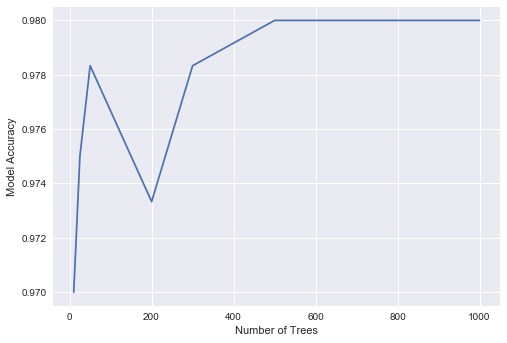

In [32]:
n = [10, 25, 50, 100, 200, 300, 500, 1000]
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
plt.plot(n, grid_mean_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Model Accuracy')
plt.show()

In [33]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.98
{'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=4,
            verbose=0, warm_start=False)


** Train Model Using Optimal Tuning Parameters**

In [34]:
model = RandomForestClassifier(n_estimators=100, random_state=4) 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=4,
            verbose=0, warm_start=False)

In [ ]:
# rf = model.fit(X_train, y_train)

In [ ]:
# # 1. Store Feature names in an array
# features = list(X_train.columns.values)
# target = list(y_train.columns.values)

In [ ]:
# def show_tree(tree, features, path):
#     f = io.StringIO()
#     export_graphviz(tree, out_file=f, feature_names=features)
#     pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
#     img = misc.imread(path)
#     plt.rcParams["figure.figsize"] = (20, 20)
#     plt.imshow(img)

In [ ]:
# show_tree(rf, features, 'rf_tree_allfeatures.png')

In [ ]:
# # Feature Importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# print("Feature ranking:")

# for f in range(X_test.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

<a id='feature_importance'></a>

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



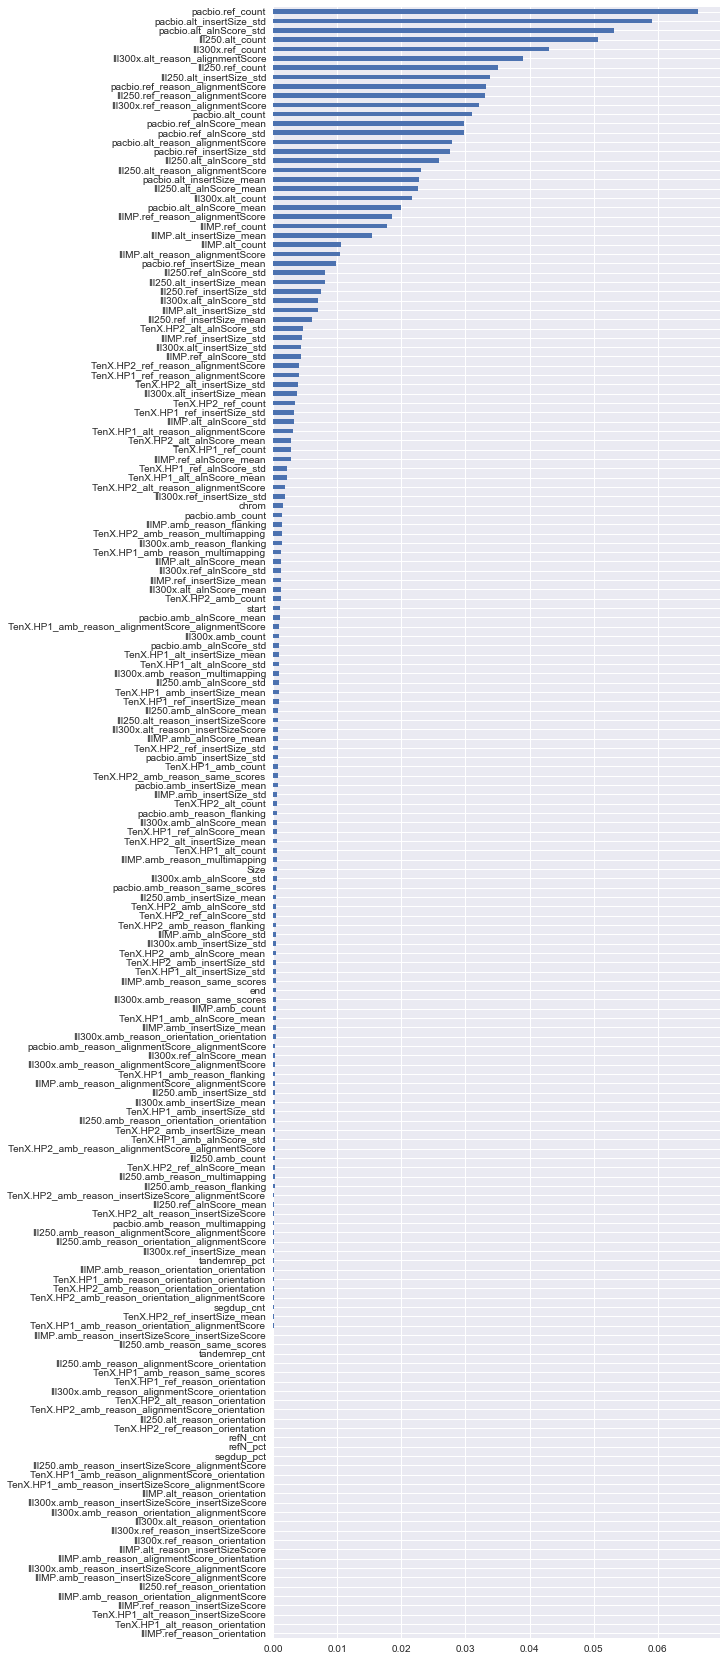

In [35]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(8,30))
plt.savefig('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_features_500trees.png', bbox_inches='tight')

In [36]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

In [37]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

1.0    139
2.0    136
0.0    145
dtype: int64

<a id='prediction_step'></a>

In [38]:
pred = model.predict(X_test)

<a id='traintest_precision'></a>

In [39]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(y_test, pred, average='micro'))) 

Precision score of the training subset: 0.989


In [40]:
from sklearn.metrics import accuracy_score
print('Accuracy score of the training subset: {:.3f}'.format(accuracy_score(y_test, pred))) 

Accuracy score of the training subset: 0.989


In [41]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,Ill250.amb_alnScore_std,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
434,938.375000,32.463842,48.0,411.666667,76.318230,48.0,0.0,0.0,872.046243,144.793727,...,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,67518763.0,1.0,1.000000
122,872.000000,0.000000,1.0,291.000000,0.000000,1.0,0.0,0.0,848.921788,115.670475,...,10869.622220,4105.451976,45.0,0.0,0.0,0.0,0.0,88840689.0,1.0,1.000000
224,920.888889,35.306419,9.0,475.222222,77.337324,9.0,0.0,0.0,869.033149,150.398877,...,9352.789474,3920.835445,19.0,0.0,0.0,0.0,0.0,165220252.0,0.0,0.000000
479,936.600000,37.675456,20.0,433.900000,65.042217,20.0,0.0,0.0,893.455000,137.583131,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,51460394.0,1.0,1.000000
205,907.800000,32.058696,5.0,515.800000,111.528292,5.0,0.0,0.0,824.633663,143.131195,...,11108.692310,2980.377554,26.0,0.0,0.0,0.0,0.0,5928792.0,1.0,0.518519


In [42]:
labels = pd.DataFrame(y_test)

In [43]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [44]:
df_Xtest['GTcons'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTcons'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTcons'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [45]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

Heterozygous_Variant    61
Homozygous_Variant      64
Homozygous_Reference    55
dtype: int64

In [46]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Heterozygous_Variant    62
Homozygous_Variant      63
Homozygous_Reference    55
dtype: int64

In [47]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[61  0  0]
 [ 1 54  0]
 [ 0  1 63]]


<a id='traintest_confusion_matrix'></a>

In [48]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,61,0,0,61
Homozygous_Reference,1,54,0,55
Homozygous_Variant,0,1,63,64
All,62,55,63,180


In [49]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.98      1.00      0.99        61
Homozygous_Reference       0.98      0.98      0.98        55
  Homozygous_Variant       1.00      0.98      0.99        64

         avg / total       0.99      0.99      0.99       180



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [ ]:
X2 = df_test

** Impute missing values using KNN **

In [ ]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

**NOTE: Error above notes that there are no missing values **

In [ ]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

In [ ]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

In [ ]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [ ]:

# X5 = df_test

<a id='prediction_step'></a>

In [ ]:
pred = model.predict(X5)

In [ ]:
pred_prob = model.predict_proba(X5)

In [ ]:
pred_prob_log = model.predict_log_proba(X5)

In [ ]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['GTcons'] = df_test_2['GTcons']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
# X5['GTconswithoutIll300x.GT'] = df_test_2['GTconswithoutIll300x.GT']
X5['GTsupp'] = df_test_2['GTsupp']

In [ ]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [ ]:
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_DEL_500trees.csv', index=False)

In [ ]:
X7.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_log_DEL_500trees.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [ ]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_DEL_500trees.csv')


In [ ]:
X6.rename(columns={'1': 'Homozygous_Reference_GTcons'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'predicted_label': 'predicted_GTcons_label'}, inplace=True)

In [ ]:
X6.head(3)

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/final_df/alldata_final_GTcons_df_DEL_SVanalyzer_500trees.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [ ]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['predicted_GTcons_label']
print(confusion_matrix(consensus_GT, predict))

In [ ]:
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['predicted_GTcons_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

<a id='predict_precision_score_matrix'></a>

In [ ]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

In [ ]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the GTcons labels predicted by the model that were also assigned a predict probability of either 0.9 or 1


In [ ]:
high_conf_labels = X6[(X6['Homozygous_Reference_GTcons'] == 1) | (X6['Homozygous_Reference_GTcons'] >= 0.9) | (X6['Heterozygous_Variant_GTcons'] == 1) | (X6['Heterozygous_Variant_GTcons'] >= 0.9) | (X6['Homozygous_Variant_GTcons'] == 1) | (X6['Homozygous_Variant_GTcons'] >= 0.9)]


<a id='hiconf_precision_score'></a>

In [ ]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['predicted_GTcons_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))